In [ ]:
#export
import qsample as qs
import qiskit
import time
import stim
import numpy as np
import matplotlib.pyplot as plt
import time
import re
from tqdm.notebook import tqdm
import pymatching

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# 

# Surface code

In [ ]:
#export
circuit = stim.Circuit.generated("surface_code:rotated_memory_x", rounds=1, distance=3)
circuit.diagram("timeline-svg")

"""
IMPORTANT NOTE: The predictions output by pyMatching depend on the error rate of the STIM circuit,
but the prediction error is nearly independent of the error rate if it is sufficient low (which is the
regime we care about in QSample anyway), so in order to generate the first detector error model and 
Matching object, it is advisable to use a physical error rate by the lower end of your range.

"""

circuit = stim.Circuit.generated("surface_code:rotated_memory_x", rounds=1, distance=3, after_clifford_depolarization=0.05,
    after_reset_flip_probability=0.001,
    before_measure_flip_probability=0.001,
    before_round_data_depolarization=0.001,)
surface_code = qs.Circuit(noisy=True).from_stim_circuit(circuit)

matching = pymatching.Matching(surface_code.dem)
num_detectors = matching.num_detectors
detector_array = surface_code.detector_array


corr = qs.Circuit(noisy=False).from_stim_circuit("""X 1 8 15""")
meas = qs.Circuit(noisy=False).from_stim_circuit("""M 1 8 15""")

round_ = 0
def reset_count():
    global round_
    round_=0
    return True

def increase_count():
    global round_
    round_+=1
    return round_

def count():
    global round_
    return round_

def int2meas(out):
    result = []
    for i in np.arange(surface_code.n_measurements)[::-1]:
        result.append(out//(2**i))
        out-=result[-1]*2**i
    return result

def measurement2detector(out, detector_array):
    out = int2meas(out[-1])
    detection_events = np.zeros(num_detectors)
    for ii in range(num_detectors):
        event = 0
        for jj in detector_array[ii]:
            event^=int(out[jj])
        detection_events[ii]=event
    return detection_events
    
def decoder(out):
    detection_events = measurement2detector(out, detector_array)
    result = matching.decode(detection_events)
    return result

def logErr(out):
    return out[0] in [1, 2, 4, 7]

functions = {'decoder': decoder, 'matching':matching, 'logErr':logErr,
            'reset_count': reset_count, 'count': count, 'increase_count': increase_count}
surface = qs.Protocol(check_functions=functions)


n_rounds = 4
surface.add_nodes_from(['SC', 'corr', 'meas'], circuits=[surface_code, corr, meas])
surface.add_node('Round_counter', circuit=qs.Circuit([{"I": {0}}],noisy=False))
surface.add_edge('START', 'Round_counter', check='reset_count()')
surface.add_edge('Round_counter', 'SC', check='increase_count()')
surface.add_edge('SC', 'corr', check='decoder(SC)')
surface.add_edge('SC', 'Round_counter', check=f'(not decoder(SC)) and count()<{n_rounds}')
surface.add_edge('SC', 'meas', check=f'(not decoder(SC)) and count()=={n_rounds}')
surface.add_edge('corr', 'Round_counter', check=f'count()<{n_rounds}')
surface.add_edge('corr', 'meas', check=f'count()=={n_rounds}')
surface.add_edge('meas', 'FAIL', check='logErr(meas)')

p=('1.00e-02',):   0%|          | 0/25000 [00:00<?, ?it/s]

time: 53.046889781951904 s


/Users/jhfontes/Desktop/qsample/qsample/sampler/subset.py:92: RuntimeWarning: invalid value encountered in sqrt
  return np.broadcast_arrays(p_L, np.sqrt(var), p_L+delta, np.sqrt(var_up))


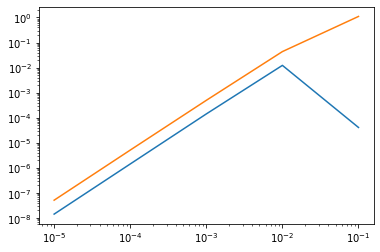

In [ ]:
#export
err_model = qs.noise.E1
q = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
err_params = {'q': q}

begin = time.time()
ss_sam = qs.SubsetSampler(protocol=surface, simulator=qs.StimSimulator,  p_max={'q': 0.01}, err_model=err_model, err_params=err_params, L=5)
ss_sam.run(25000)
end = time.time()
qsample_time = end-begin

v1 = ss_sam.stats()[0]
w1 = ss_sam.stats()[2]

plt.plot(q, v1)
plt.plot(q, w1)
plt.xscale('log')
plt.yscale('log')
print('time:', qsample_time, 's')

In [ ]:
"""
IMPORTANT NOTE: The predictions output by pyMatching depend on the error rate of the STIM circuit,
but the prediction error is nearly independent of the error rate if it is sufficient low (which is the
regime we care about in QSample anyway), so in order to generate the first detector error model and 
Matching object, it is advisable to use a physical error rate by the lower end of your range.
"""

circuit = stim.Circuit.generated("surface_code:rotated_memory_x", rounds=1, distance=3, after_clifford_depolarization=0.05,
    after_reset_flip_probability=0.001,
    before_measure_flip_probability=0.001,
    before_round_data_depolarization=0.001,)
surface_code = qs.Circuit(noisy=True).from_stim_circuit(circuit)

matching = pymatching.Matching(surface_code.dem)
num_detectors = matching.num_detectors
detector_array = surface_code.detector_array


corr = qs.Circuit(noisy=False).from_stim_circuit("""X 1 8 15""")
meas = qs.Circuit(noisy=False).from_stim_circuit("""M 1 8 15""")

round_ = 0
def reset_count():
    global round_
    round_=0
    return True

def increase_count():
    global round_
    round_+=1
    return round_

def count():
    global round_
    return round_

def int2meas(out):
    result = []
    for i in np.arange(surface_code.n_measurements)[::-1]:
        result.append(out//(2**i))
        out-=result[-1]*2**i
    return result

def measurement2detector(out, detector_array):
    out = int2meas(out[-1])
    detection_events = np.zeros(num_detectors)
    for ii in range(num_detectors):
        event = 0
        for jj in detector_array[ii]:
            event^=int(out[jj])
        detection_events[ii]=event
    return detection_events
    
def decoder(out):
    detection_events = measurement2detector(out, detector_array)
    result = matching.decode(detection_events)
    return result

def logErr(out):
    return out[0] in [1, 2, 4, 7]

functions = {'decoder': decoder, 'matching':matching, 'logErr':logErr,
            'reset_count': reset_count, 'count': count, 'increase_count': increase_count}
surface = qs.Protocol(check_functions=functions)


n_rounds = 1
surface.add_nodes_from(['SC', 'corr', 'meas'], circuits=[surface_code, corr, meas])
surface.add_node('Round_counter', circuit=qs.Circuit([{"I": {0}}],noisy=False))
surface.add_edge('START', 'Round_counter', check='reset_count()')
surface.add_edge('Round_counter', 'SC', check='increase_count()')
surface.add_edge('SC', 'corr', check='decoder(SC)')
surface.add_edge('SC', 'Round_counter', check=f'(not decoder(SC)) and count()<{n_rounds}')
surface.add_edge('SC', 'meas', check=f'(not decoder(SC)) and count()=={n_rounds}')
surface.add_edge('corr', 'Round_counter', check=f'count()<{n_rounds}')
surface.add_edge('corr', 'meas', check=f'count()=={n_rounds}')
surface.add_edge('meas', 'FAIL', check='logErr(meas)')

p=('1.00e-02',):   0%|          | 0/25000 [00:00<?, ?it/s]

/Users/jhfontes/Desktop/qsample/qsample/sampler/subset.py:92: RuntimeWarning: invalid value encountered in sqrt
  return np.broadcast_arrays(p_L, np.sqrt(var), p_L+delta, np.sqrt(var_up))


time: 14.701840162277222 s


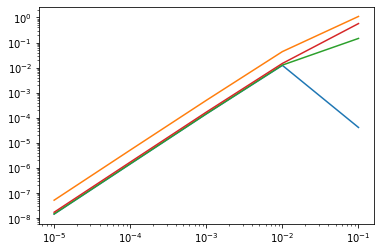

In [ ]:
err_model = qs.noise.E1
q = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
err_params = {'q': q}

begin = time.time()
ss_sam = qs.SubsetSampler(protocol=surface, simulator=qs.StimSimulator,  p_max={'q': 0.01}, err_model=err_model, err_params=err_params, L=5)
ss_sam.run(25000)
end = time.time()
qsample_time = end-begin

v1b = ss_sam.stats()[0]
w1b = ss_sam.stats()[2]

plt.plot(q, v1)
plt.plot(q, w1)
plt.plot(q, v1b)
plt.plot(q, w1b)
plt.xscale('log')
plt.yscale('log')
print('time:', qsample_time, 's')

In [ ]:
"""
IMPORTANT NOTE: The predictions output by pyMatching depend on the error rate of the STIM circuit,
but the prediction error is nearly independent of the error rate if it is sufficient low (which is the
regime we care about in QSample anyway), so in order to generate the first detector error model and 
Matching object, it is advisable to use a physical error rate by the lower end of your range.
"""

circuit = stim.Circuit.generated("surface_code:rotated_memory_x", rounds=1, distance=3, after_clifford_depolarization=0.05,
    after_reset_flip_probability=0.001,
    before_measure_flip_probability=0.001,
    before_round_data_depolarization=0.001,)
surface_code = qs.Circuit(noisy=True).from_stim_circuit(circuit)

matching = pymatching.Matching(surface_code.dem)
num_detectors = matching.num_detectors
detector_array = surface_code.detector_array


corr = qs.Circuit(noisy=False).from_stim_circuit("""X 1 8 15""")
meas = qs.Circuit(noisy=False).from_stim_circuit("""M 1 8 15""")

round_ = 0
def reset_count():
    global round_
    round_=0
    return True

def increase_count():
    global round_
    round_+=1
    return round_

def count():
    global round_
    return round_

def int2meas(out):
    result = []
    for i in np.arange(surface_code.n_measurements)[::-1]:
        result.append(out//(2**i))
        out-=result[-1]*2**i
    return result

def measurement2detector(out, detector_array):
    out = int2meas(out[-1])
    detection_events = np.zeros(num_detectors)
    for ii in range(num_detectors):
        event = 0
        for jj in detector_array[ii]:
            event^=int(out[jj])
        detection_events[ii]=event
    return detection_events
    
def decoder(out):
    detection_events = measurement2detector(out, detector_array)
    result = matching.decode(detection_events)
    return result

def logErr(out):
    return out[0] in [1, 2, 4, 7]

functions = {'decoder': decoder, 'matching':matching, 'logErr':logErr,
            'reset_count': reset_count, 'count': count, 'increase_count': increase_count}
surface = qs.Protocol(check_functions=functions)


n_rounds = 8
surface.add_nodes_from(['SC', 'corr', 'meas'], circuits=[surface_code, corr, meas])
surface.add_node('Round_counter', circuit=qs.Circuit([{"I": {0}}],noisy=False))
surface.add_edge('START', 'Round_counter', check='reset_count()')
surface.add_edge('Round_counter', 'SC', check='increase_count()')
surface.add_edge('SC', 'corr', check='decoder(SC)')
surface.add_edge('SC', 'Round_counter', check=f'(not decoder(SC)) and count()<{n_rounds}')
surface.add_edge('SC', 'meas', check=f'(not decoder(SC)) and count()=={n_rounds}')
surface.add_edge('corr', 'Round_counter', check=f'count()<{n_rounds}')
surface.add_edge('corr', 'meas', check=f'count()=={n_rounds}')
surface.add_edge('meas', 'FAIL', check='logErr(meas)')

In [ ]:
"""RUNTIME > 20 min

err_model = qs.noise.E1
q = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
err_params = {'q': q}

begin = time.time()
ss_sam = qs.SubsetSampler(protocol=surface, simulator=qs.StimSimulator,  p_max={'q': 0.01}, err_model=err_model, err_params=err_params, L=5)
ss_sam.run(25000)
end = time.time()
qsample_time = end-begin

v1 = ss_sam.stats()[0]
w1 = ss_sam.stats()[2]

plt.plot(q, v1)
plt.plot(q, w1)
plt.xscale('log')
plt.yscale('log')
print('time:', qsample_time, 's')
"""

p=('1.00e-02',):   0%|          | 0/25000 [00:00<?, ?it/s]

KeyboardInterrupt: 